In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

tqdm.pandas()

/tmp/ipykernel_59541/1403109012.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
DATASET_DIR = Path("../dataset")

In [3]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [4]:
import re

from typing import List, Tuple, Dict

import torch

from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BasicTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split


class MultiLabelDataset(Dataset):
    def __init__(
        self,
        data: pd.Series,
        labels: List[int],
        tokenizer: BasicTokenizer,
        max_seq_length: int = 512,
    ) -> None:
        self.data = data
        self.labels = torch.tensor(labels, dtype=torch.float)
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.input_ids, self.attention_mask = self._get_features(self.data)

    def _get_features(self, data: pd.Series) -> Tuple[torch.Tensor]:
        features = self.tokenizer(
            data.tolist(),
            max_length=self.max_seq_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return features["input_ids"], features["attention_mask"]

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        return {
            "input_ids": self.input_ids[index],
            "attention_mask": self.attention_mask[index],
            "labels": self.labels[index],
        }

    def __len__(self) -> int:
        return self.data.count()

In [5]:
import re
from bs4 import BeautifulSoup

from typing import Any, Union, List, Callable, Tuple, Optional

import torch
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BasicTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)


class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(
        self,
        model_name_or_path: str,
        dataset_path: str,
        test_path: str,
        max_seq_length: int = 512,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        test_size: float = 0.2,
        **kwargs: Any,
    ) -> None:
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        self.dataset = pd.read_parquet(
            dataset_path, columns=["comment_text", "labels", "label_w"]
        )
        self.testset = pd.read_parquet(
            test_path, columns=["comment_text", "labels", "label_w"]
        )
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.test_size = test_size

    def create_sampler(self, data: pd.Series) -> WeightedRandomSampler:
        data = data.to_numpy()
        return WeightedRandomSampler(
            weights=torch.from_numpy(data).type(torch.double),
            num_samples=len(data),
        )

    def setup(self, stage: str):
        train_df, val_df = train_test_split(self.dataset, test_size=self.test_size)
        train_labels = train_df["labels"].tolist()
        val_labels = val_df["labels"].tolist()
        test_labels = self.testset["labels"].tolist()
        self.train_sampler = self.create_sampler(train_df["label_w"])
        self.train_dataset = MultiLabelDataset(
            train_df["comment_text"],
            train_labels,
            self.tokenizer,
            self.max_seq_length,
        )
        self.val_dataset = MultiLabelDataset(
            val_df["comment_text"],
            val_labels,
            self.tokenizer,
            self.max_seq_length,
        )
        self.test_dataset = MultiLabelDataset(
            self.testset["comment_text"],
            test_labels,
            self.tokenizer,
            self.max_seq_length,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.eval_batch_size)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            sampler=self.train_sampler,
        )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.eval_batch_size)

In [6]:
import torchmetrics


class ToxicCommentClassifier(pl.LightningModule):
    def __init__(
        self,
        model_name_or_path: str,
        label_classes: List[str],
        steps_per_epoch: Optional[int] = None,
        n_epochs: int = 3,
        lr: float = 1e-3,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.id2label = {idx: label for idx, label in enumerate(label_classes)}
        self.label2id = {label: idx for idx, label in enumerate(label_classes)}
        self.num_labels = len(label_classes)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name_or_path,
            num_labels=self.num_labels,
            id2label=self.id2label,
            label2id=self.label2id,
            problem_type="multi_label_classification",
        )
        self.f1 = torchmetrics.F1Score(task="multilabel", num_labels=self.num_labels)
        self.t_acc = torchmetrics.Accuracy(
            task="multilabel", num_labels=self.num_labels
        )
        self.t_f1 = torchmetrics.F1Score(task="multilabel", num_labels=self.num_labels)
        self.v_acc = torchmetrics.Accuracy(
            task="multilabel", num_labels=self.num_labels
        )
        self.v_f1 = torchmetrics.F1Score(task="multilabel", num_labels=self.num_labels)

    def forward(self, **inputs: Any) -> Any:
        return self.model(**inputs)

    def training_step(
        self, batch: Tuple[List[int], List[int]], batch_idx: int
    ) -> float:
        outputs = self(**batch)
        loss = outputs.loss
        preds = torch.sigmoid(outputs.logits)
        labels = batch["labels"]
        self.log("train_loss", loss)
        self.f1(preds, labels)
        self.log("train_f1", self.f1, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def test_step(self, batch: Tuple[List[int], List[int]], batch_idx: int) -> float:
        outputs = self(**batch)
        loss, logits = outputs[:2]
        preds = torch.sigmoid(logits)
        labels = batch["labels"]
        self.log("test_loss", loss)
        self.t_acc.update(preds, labels)
        self.t_f1.update(preds, labels)
        return {"loss": loss, "preds": preds, "labels": labels}

    def test_epoch_end(self, outputs):
        self.log(
            "test_acc",
            self.t_acc.compute(),
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_f1", self.t_f1.compute(), on_step=False, on_epoch=True, prog_bar=True
        )
        self.t_acc.reset()
        self.t_f1.reset()

    def validation_step(
        self, batch: Tuple[List[int], List[int]], batch_idx: int
    ) -> float:
        outputs = self(**batch)
        val_loss, logits = outputs[:2]
        preds = torch.sigmoid(logits)
        labels = batch["labels"]
        self.log("val_loss", val_loss)
        self.v_acc.update(preds, labels)
        self.v_f1.update(preds, labels)
        return {"loss": val_loss, "preds": preds, "labels": labels}

    def validation_epoch_end(self, outputs):
        self.log(
            "valid_acc",
            self.v_acc.compute(),
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "valid_f1", self.v_f1.compute(), on_step=False, on_epoch=True, prog_bar=True
        )
        self.v_acc.reset()
        self.v_f1.reset()

    def configure_optimizers(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate": 0.01,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.lr)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(
            optimizer, warmup_steps, total_steps
        )

        return [optimizer], [scheduler]

In [7]:
# import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "roberta-base"
pl_dataset = ToxicCommentDataModule(
    model_name_or_path=model_name,
    dataset_path=str(Path(DATASET_DIR) / "train.parquet"),
    test_path=str(Path(DATASET_DIR) / "test.parquet"),
    max_seq_length=512,
    train_batch_size=10,
    eval_batch_size=8,
    test_size=0.2,
)
pl_dataset.setup("fit")

model_path = "../checkpoints/lightning_logs/model_fit.ckpt"
if Path(model_path).exists():
    pl_model = ToxicCommentClassifier.load_from_checkpoint(model_path)
else:
    pl_model = ToxicCommentClassifier(
        model_name_or_path=model_name, label_classes=labels, steps_per_epoch=3000 // 12
    )

print("finished")

/tmp/ipykernel_59541/3167931083.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.labels = torch.tensor(labels, dtype= torch.float)
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassi

finished


In [9]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min",
)
acc_checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    filename="aac_{epoch}-{val_loss:.2f}-{valid_acc:.2f}",
    save_top_k=5,
)
loss_checkpoint_callback = ModelCheckpoint(
    monitor="valid_f1",
    filename="loss_{epoch}-{val_loss:.2f}-{valid_f1:.2f}",
    save_top_k=5,
)

trainer = pl.Trainer(
    max_epochs=15,
    limit_train_batches=4000,
    limit_test_batches=2000,
    accelerator="gpu",
    devices=1,
    default_root_dir="../checkpoints",
    callbacks=[early_stop_callback, loss_checkpoint_callback, acc_checkpoint_callback],
    reload_dataloaders_every_n_epochs=5,
)
trainer.fit(
    pl_model,
    datamodule=pl_dataset,
)
trainer.save_checkpoint(model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ntub/Documents/190k-medium-articles/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | RobertaForSequenceClassification | 124 M 
1 | f1    | MultilabelF1Score                | 0     
2 | t_acc | MultilabelAccuracy               | 0     
3 | t_f1  | MultilabelF1Score                | 0     
4 | v_acc | MultilabelAccuracy               | 0     
5 | v_f1  | MultilabelF1Score                | 0     
----------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/ntub/Documents/190k-medium-articles/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ntub/Documents/190k-medium-articles/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [10]:
trainer.save_checkpoint(model_path)

In [9]:
# ["comment_text", "labels"]
text_df = pd.read_parquet(
    DATASET_DIR / "train.parquet",
    columns=["comment_text", "labels"],
)
device = torch.device("cuda:0" if not torch.cuda.is_available() else "cpu")
t_tokenizer = AutoTokenizer.from_pretrained(model_name)
t_text = text_df.iloc[1003]["comment_text"]
t_features = t_tokenizer(
    [t_text],
    max_length=512,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt",
)
t_inputs = {
    "input_ids": t_features["input_ids"].to(device),
    "attention_mask": t_features["attention_mask"].to(device),
}

In [18]:
outputs = pl_model(**t_inputs)

In [19]:
print(text_df.iloc[1003]["labels"])

[1 0 1 0 0 0]


In [25]:
probs = outputs.logits.squeeze().sigmoid().detach().cpu().numpy()
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1

In [26]:
predicted_labels = [
    pl_model.id2label[idx] for idx, label in enumerate(predictions) if label == 1.0
]

In [27]:
predicted_labels

['toxic', 'obscene']

In [28]:
print(predictions)

[1. 0. 1. 0. 0. 0.]


In [8]:
text_df = pd.read_parquet(
    DATASET_DIR / "train.parquet",
    columns=["comment_text", "labels"],
)
device = torch.device("cuda:0" if not torch.cuda.is_available() else "cpu")
t_text = text_df.iloc[1003]["comment_text"]
print(text_df.iloc[1003]["labels"])

[1 0 1 0 0 0]


In [9]:
from transformers import pipeline

In [11]:
pipe = pipeline(
    "text-classification", device=device, model=pl_model.model, tokenizer=model_name
)

In [22]:
result = pipe(t_text, top_k=6)
result

[{'label': 'toxic', 'score': 0.9887962341308594},
 {'label': 'obscene', 'score': 0.9501343369483948},
 {'label': 'insult', 'score': 0.08250889927148819},
 {'label': 'severe_toxic', 'score': 0.006672219838947058},
 {'label': 'threat', 'score': 0.001292090630158782},
 {'label': 'identity_hate', 'score': 0.0008219154551625252}]

In [21]:
[item["label"] for item in result if item["score"] >= 0.5]

['toxic', 'obscene']

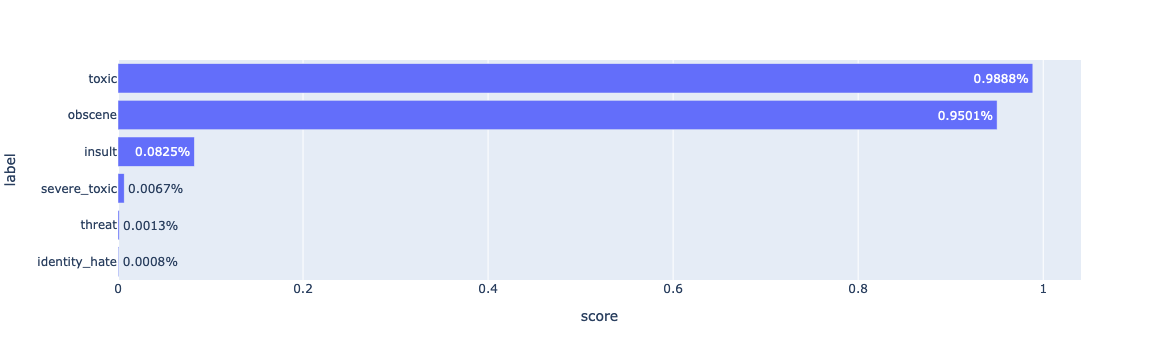

In [27]:
import plotly.express as px

result_df = pd.DataFrame(result)
result_df["text"] = result_df["score"].apply(lambda x: f"{x:.4f}%")
result_df = result_df.sort_values(by="score")

fig = px.bar(
    result_df,
    x="score",
    y="label",
    text="text",
    orientation="h",
    hover_data=["label", "score"],
)
fig.show()